# Analyze earthquake data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import ks_2samp, poisson
from sklearn.neighbors import KernelDensity
import numpy as np

In [2]:
# load data from a CSV file
df = pd.read_csv('data/query.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             1133 non-null   object 
 1   latitude         1133 non-null   float64
 2   longitude        1133 non-null   float64
 3   depth            1133 non-null   float64
 4   mag              1133 non-null   float64
 5   magType          1133 non-null   object 
 6   nst              475 non-null    float64
 7   gap              738 non-null    float64
 8   dmin             436 non-null    float64
 9   rms              1133 non-null   float64
 10  net              1133 non-null   object 
 11  id               1133 non-null   object 
 12  updated          1133 non-null   object 
 13  place            1133 non-null   object 
 14  type             1133 non-null   object 
 15  horizontalError  399 non-null    float64
 16  depthError       691 non-null    float64
 17  magError      

In [3]:
# Preprocessing

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Extract year
df['year'] = df['time'].dt.year

In [4]:
# -------------------------------
# REGION FILTER: BANGLADESH + NEARBY
# -------------------------------
# Define region bounding box
# Bangladesh approx: lat 20.5–26.5, lon 88–92.5
# Add margin ±2 degrees for "nearby"
min_lat, max_lat = 18.5, 28.5
min_lon, max_lon = 86, 94.5

region_df = df[
    (df['latitude'].between(min_lat, max_lat)) &
    (df['longitude'].between(min_lon, max_lon))
].copy()

print("Total earthquakes in filtered region:", len(region_df))

Total earthquakes in filtered region: 1133


## Are we looking into the right dataset ?

In [5]:
# Filter data for earthquakes with magnitude >= 5 in the year 2025
# Create a scatter geo plot using Plotly to visualize earthquake locations and magnitudes on a world map
# This is to make sure we are looking into the right subset of data

filtered_data = region_df[(region_df['mag'] >= 5) & (region_df['year'] == 2025)]

fig = px.scatter_geo(filtered_data,
                     lat='latitude',
                     lon='longitude',
                     size='mag',
                     hover_name='place',
                     projection='natural earth',
                     title='Earthquake Magnitude Distribution (Magnitude >= 5) on Earth Map')
fig.update_traces(marker=dict(
    colorscale='Viridis',
    color=filtered_data['mag'],
    colorbar=dict(title='Magnitude'),
    showscale=True
))
fig.update_geos(showland=True, landcolor="LightGreen", showocean=True, oceancolor="LightBlue")
fig.show()

## Has the number of earthquakes changed unusually?

Questions to ask:

- How many earthquakes occurred this year vs. each previous year?
- Is the frequency significantly higher or lower than the long-term average?

Analysis to run:

- Year-over-year event counts
- Rolling trends (e.g., 5-year moving average)
- Anomaly detection on counts


Yearly earthquake counts:
 year
1985     2
1986    12
1987    13
1988    30
1989    17
1990    19
1991    24
1992    30
1993    17
1994    21
1995    22
1996    41
1997    22
1998    29
1999    20
2000    23
2001    30
2002    23
2003    27
2004    28
2005    29
2006    34
2007    28
2008    45
2009    27
2010    11
2011    30
2012    28
2013    30
2014    44
2015    61
2016    27
2017    23
2018    24
2019    31
2020    48
2021    43
2022    21
2023    34
2024    36
2025    29
dtype: int64


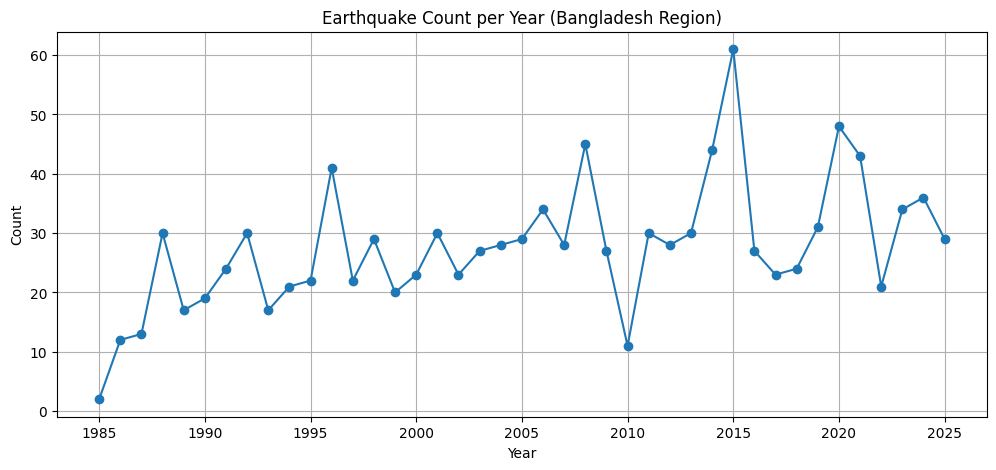

In [6]:
# -------------------------------
# 3. YEARLY EARTHQUAKE COUNTS
# -------------------------------
yearly_counts = region_df.groupby('year').size()

print("\nYearly earthquake counts:\n", yearly_counts)

plt.figure(figsize=(12,5))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.title("Earthquake Count per Year (Bangladesh Region)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## Is the magnitude distribution different?

- Is the proportion of moderate/strong earthquakes (e.g., M≥4, M≥5) higher this year?
- Did the maximum magnitude this year change significantly compared to previous years?
- Has the median magnitude increased or decreased?

Analysis to run:

1. Histograms of magnitude by year
2. Comparison of magnitude percentiles (median, 90th percentile, etc.)
3. Kolmogorov–Smirnov test on magnitude distributions (optional)

/var/folders/xt/8vlf86b12sj97ydvhg75641r0000gn/T/ipykernel_39248/2171494944.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



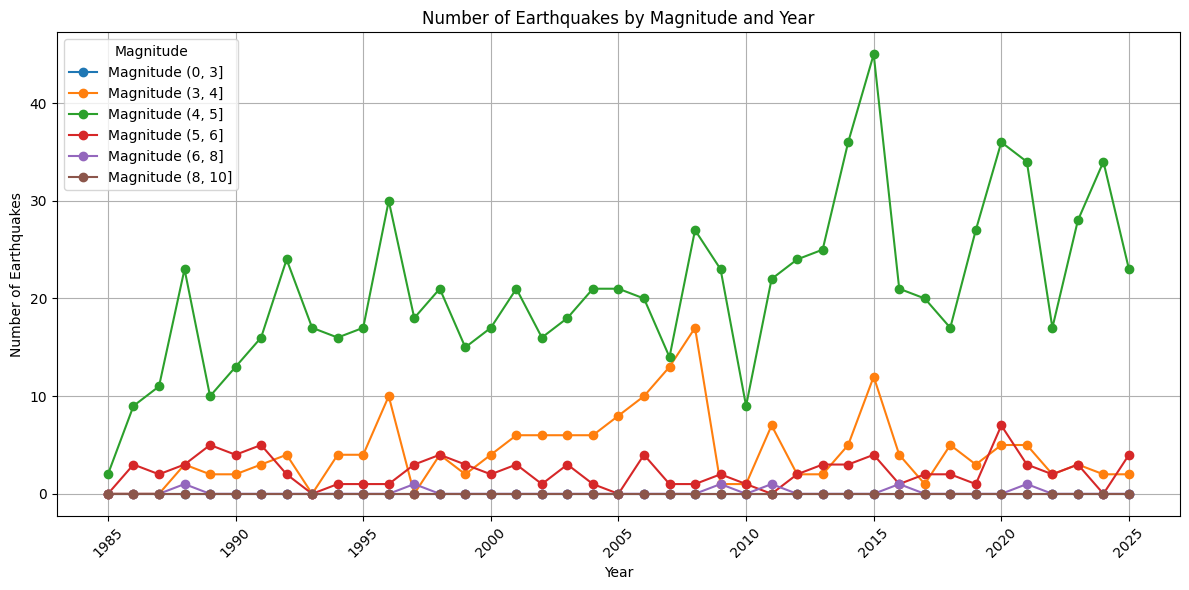

In [7]:
# -------------------------------
# 4. MAGNITUDE IMPACT ON YEARLY EARTHQUAKE COUNTS
# -------------------------------
# Now i want to see the impact of magnitude on the
# number of earthquakes through the years

magnitude_bins = [0, 3, 4, 5, 6, 8, 10]
region_df['magnitude_bin'] = pd.cut(region_df['mag'], bins=magnitude_bins)
magnitude_yearly_counts = region_df.groupby(['magnitude_bin', 'year']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
for mag_bin in magnitude_yearly_counts.index:
    plt.plot(magnitude_yearly_counts.columns, magnitude_yearly_counts.loc[mag_bin], marker='o', label=f'Magnitude {mag_bin}')
plt.title('Number of Earthquakes by Magnitude and Year')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid()
plt.xticks(rotation=45)
plt.legend(title='Magnitude')
plt.tight_layout()
plt.show()



Magnitude distribution stats per year:
          mean   50%       std  min  max
year                                    
1985  4.750000  4.75  0.353553  4.5  5.0
1986  4.808333  4.75  0.350216  4.3  5.4
1987  4.730769  4.80  0.311942  4.1  5.3
1988  4.700000  4.60  0.581911  4.0  6.9
1989  4.723529  4.60  0.559609  3.9  5.8
1990  4.594737  4.50  0.462450  3.8  5.3
1991  4.691667  4.70  0.502097  3.5  5.5
1992  4.420000  4.35  0.406329  3.6  5.3
1993  4.529412  4.60  0.266375  4.1  5.0
1994  4.485714  4.60  0.445293  3.7  5.8
1995  4.404545  4.40  0.407638  3.7  5.5
1996  4.312195  4.30  0.384834  3.6  5.4
1997  4.736364  4.50  0.531436  4.1  6.1
1998  4.506897  4.50  0.452715  3.8  5.6
1999  4.515000  4.40  0.424605  4.0  5.6
2000  4.373913  4.30  0.423425  3.7  5.5
2001  4.393333  4.30  0.425833  3.5  5.2
2002  4.334783  4.30  0.366319  3.8  5.1
2003  4.429630  4.30  0.503690  3.8  5.7
2004  4.300000  4.20  0.347478  3.6  5.4
2005  4.251724  4.30  0.388790  3.5  5.0
2006  4.370588  4

<Figure size 1200x600 with 0 Axes>

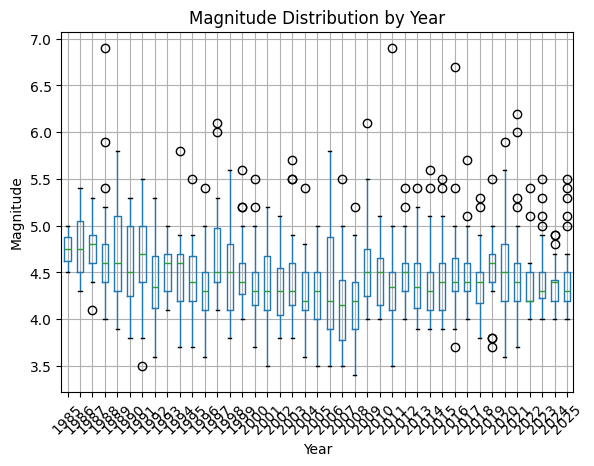

In [8]:
# -------------------------------
# 5. MAGNITUDE DISTRIBUTION CHANGES
# -------------------------------
mag_by_year = region_df.groupby('year')['mag']

print("\nMagnitude distribution stats per year:")
print(mag_by_year.describe()[['mean','50%','std','min','max']])

# Boxplot for visual comparison
plt.figure(figsize=(12,6))
region_df.boxplot(column='mag', by='year')
plt.title("Magnitude Distribution by Year")
plt.suptitle("")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylabel("Magnitude")
plt.show()

In [9]:
# -------------------------------
# 6. MAGNITUDE DISTRIBUTION ON EARTH MAP
# -------------------------------
# View magnitude distribution of earthquakes in a earth map -
# based on their latitude and longitude with radius based on magnitude.
# different color for different magnitude ranges

fig = px.scatter_geo(region_df,
                     lat='latitude',
                     lon='longitude',
                     size='mag',
                     hover_name='place',
                     projection='natural earth',
                     title='Earthquake Magnitude Distribution on Earth Map')

fig.update_traces(marker=dict(
    colorscale='Viridis',
    color=region_df['mag'],
    colorbar=dict(title='Magnitude'),
    showscale=True
))
fig.update_geos(showland=True, landcolor="LightGreen", showocean=True, oceancolor="LightBlue")
fig.show()

## 3. Has the total seismic energy changed?

Magnitude is logarithmic, so one large event can dominate energy release.

Questions:

- What is the total seismic energy released this year vs. previous years?
- Is the cumulative energy curve steeper or flatter this year?

Analysis:

- Convert magnitude to seismic moment or energy
- Plot cumulative energy per year


Total seismic energy per year (Joules):
 year
1985    2.350076e+12
1986    2.420119e+13
1987    1.677545e+13
1988    1.484080e+15
1989    6.797388e+13
1990    2.512666e+13
1991    4.902406e+13
1992    2.159336e+13
1993    9.655813e+12
1994    4.046697e+13
1995    1.906602e+13
1996    2.182128e+13
1997    1.720084e+14
1998    3.797554e+13
1999    2.959704e+13
2000    2.141907e+13
2001    2.037778e+13
2002    9.931435e+12
2003    5.180016e+13
2004    1.434490e+13
2005    9.227611e+12
2006    5.713050e+13
2007    1.881202e+13
2008    1.462902e+13
2009    1.145367e+14
2010    6.282209e+12
2011    1.422588e+15
2012    2.288595e+13
2013    2.345895e+13
2014    3.707731e+13
2015    4.495908e+13
2016    7.254808e+14
2017    3.339710e+13
2018    1.621587e+13
2019    2.660255e+13
2020    1.035993e+14
2021    2.120498e+14
2022    1.501773e+13
2023    3.117064e+13
2024    1.132744e+13
2025    3.422305e+13
Name: energy_joules, dtype: float64


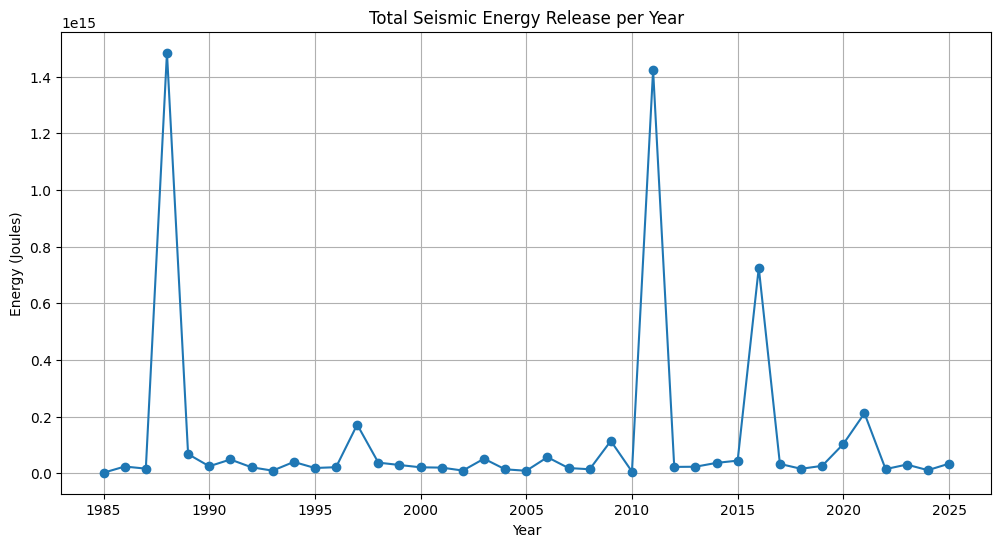

In [10]:
# -------------------------------
# 5. TOTAL SEISMIC ENERGY RELEASE
# -------------------------------
# Gutenberg–Richter: log10(E) ≈ 1.5M + 4.8
region_df['energy_joules'] = 10 ** (1.5 * region_df['mag'] + 4.8)

energy_by_year = region_df.groupby('year')['energy_joules'].sum()

print("\nTotal seismic energy per year (Joules):\n", energy_by_year)

plt.figure(figsize=(12,6))
plt.plot(energy_by_year.index, energy_by_year.values, marker='o')
plt.title("Total Seismic Energy Release per Year")
plt.xlabel("Year")
plt.ylabel("Energy (Joules)")
plt.grid(True)
plt.show()

## 4. Are quake depths behaving differently?

Depth changes can indicate shifts in the type of seismicity.

Questions:

- Are earthquakes shallower or deeper on average this year?
- Are there more crustal vs. intermediate vs. deep quakes?

Analysis:

- Yearly depth distributions
- Boxplots of depth by year


Depth distribution stats per year:
           mean     50%        std    min      max
year                                              
1985  30.850000  30.850  25.667976  12.70   49.000
1986  53.125000  46.200  24.035206  17.50   94.800
1987  44.653846  47.600  12.802904  27.30   74.300
1988  44.860000  33.000  16.808528  28.90   89.200
1989  43.676471  33.800  21.018371   5.80  104.500
1990  58.421053  33.000  41.257034  33.00  170.200
1991  46.170833  33.000  17.780142  33.00   85.300
1992  46.460000  33.000  24.387767  29.30  129.400
1993  48.576471  33.000  27.789533  27.70  130.900
1994  34.776190  33.000  11.299155  10.00   76.200
1995  41.845455  33.000  17.443698  20.00  100.000
1996  44.221951  33.000  24.256118  17.80  129.200
1997  45.859091  33.950  17.876019  33.00  100.000
1998  41.848276  33.000  20.352547  22.30  100.000
1999  42.835000  33.000  16.032016  10.00   72.800
2000  35.952174  33.000  13.915618  14.00   92.700
2001  33.046667  33.000  12.619955  10.00   60

<Figure size 1200x500 with 0 Axes>

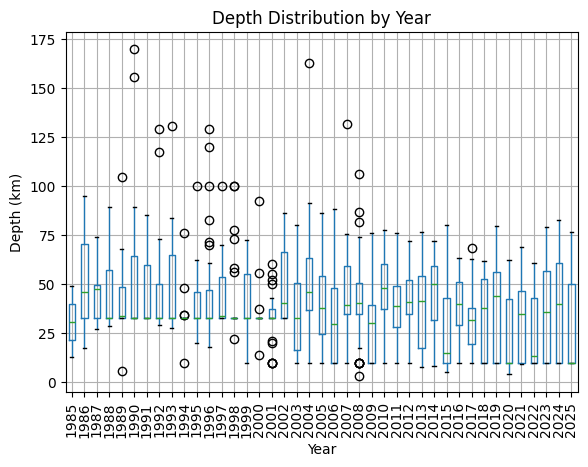

In [11]:
# -------------------------------
# 6. DEPTH DISTRIBUTION CHANGES
# -------------------------------
depth_by_year = region_df.groupby('year')['depth']

print("\nDepth distribution stats per year:")
print(depth_by_year.describe()[['mean','50%','std','min','max']])

plt.figure(figsize=(12,5))
region_df.boxplot(column='depth', by='year')
plt.title("Depth Distribution by Year")
plt.suptitle("")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Depth (km)")
plt.show()

## 5. Did earthquakes cluster differently in space or time?

Questions:

- Are earthquakes occurring in new locations this year?
- Is there a tighter spatial cluster than usual (possible swarm)?
- Are inter-event times shorter (indicating higher activity)?

Analysis:

- Spatial clustering (scatter maps, density heatmaps)
- Kernel density estimation of locations year over year
- Inter-event time distribution comparison

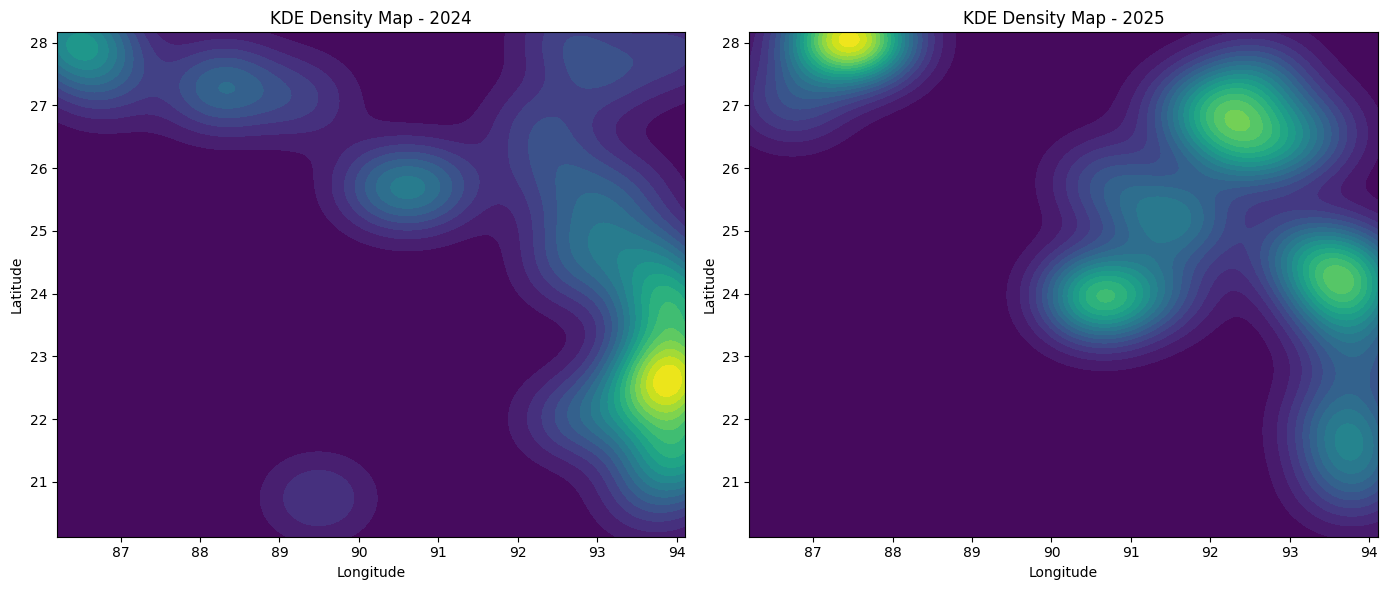

In [ ]:
# -------------------------------
# 7. Inter-Event Time Analysis
# -------------------------------
# Inter-event times show whether quakes are happening closer together.
# Extract coordinates
coords = region_df[['longitude', 'latitude']].values

# KDE model for entire dataset
kde = KernelDensity(bandwidth=0.5, kernel='gaussian').fit(coords)

# Make yearly KDE to compare clustering
kde_years = {}
for y in region_df['year'].unique():
    pts = region_df[region_df['year'] == y][['longitude', 'latitude']].values
    if len(pts) > 2:
        kde_years[y] = KernelDensity(bandwidth=0.5).fit(pts)

# Plot KDE heatmap for this year vs last year
current_year = region_df['year'].max()
previous_year = current_year - 1

def plot_kde(year, ax):
    if year not in kde_years:
        ax.text(0.5, 0.5, f"No KDE for {year}", ha='center')
        return
    kde = kde_years[year]

    lon = region_df['longitude']
    lat = region_df['latitude']

    lon_lin = np.linspace(lon.min(), lon.max(), 200)
    lat_lin = np.linspace(lat.min(), lat.max(), 200)
    xx, yy = np.meshgrid(lon_lin, lat_lin)
    grid = np.vstack([xx.ravel(), yy.ravel()]).T

    zz = np.exp(kde.score_samples(grid)).reshape(xx.shape)
    ax.contourf(xx, yy, zz, levels=20)
    ax.set_title(f"KDE Density Map - {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plot_kde(previous_year, axs[0])
plot_kde(current_year, axs[1])
plt.tight_layout()
plt.show()

In [18]:
# -------------------------------
# 8. SWARM / AFTERSHOCK DETECTION
# -------------------------------
# A swarm = many small events clustered in time and space, without
# a major mainshock.
# An aftershock sequence = smaller quakes after a large one.

# Define mainshock threshold
MAINSHOCK_MAG = 5.0

# Identify mainshocks
mainshocks = region_df[region_df['mag'] >= MAINSHOCK_MAG]

aftershock_sequences = []

for idx, main in mainshocks.iterrows():
    window = region_df[
        (region_df['time'] > main['time']) &
        (region_df['time'] <= main['time'] + pd.Timedelta(days=7)) &  # 7-day aftershock window
        (region_df['latitude'].between(main['latitude'] - 0.5, main['latitude'] + 0.5)) &
        (region_df['longitude'].between(main['longitude'] - 0.5, main['longitude'] + 0.5))
    ]
    if len(window) > 0:
        aftershock_sequences.append((main, window))

print(f"Detected {len(aftershock_sequences)} aftershock sequences.")
for main, aftershocks in aftershock_sequences:
    print(f"\nMainshock: {main['time']} Mag {main['mag']} at ({main['latitude']}, {main['longitude']})")
    print(f"Aftershocks:\n", aftershocks[['time', 'mag', 'latitude', 'longitude']])


Detected 40 aftershock sequences.

Mainshock: 1988-04-20 06:40:25.910000+00:00 Mag 5.4 at (27.042, 86.694)
Aftershocks:
                                  time  mag  latitude  longitude
1096 1988-04-25 16:04:02.760000+00:00  4.8    26.817     86.625

Mainshock: 1988-08-20 23:09:09.560000+00:00 Mag 6.9 at (26.755, 86.616)
Aftershocks:
                                  time  mag  latitude  longitude
1089 1988-08-22 11:34:33.340000+00:00  4.3    26.662     86.916
1088 1988-08-24 09:55:33.620000+00:00  4.7    26.746     86.549

Mainshock: 1989-12-02 19:44:26.770000+00:00 Mag 5.3 at (21.24, 93.79)
Aftershocks:
                                  time  mag  latitude  longitude
1061 1989-12-03 10:58:18.080000+00:00  4.7    21.218     93.710
1060 1989-12-08 00:04:25.450000+00:00  5.5    21.184     93.746
1059 1989-12-08 02:47:52.690000+00:00  3.9    21.058     93.658

Mainshock: 1989-12-08 00:04:25.450000+00:00 Mag 5.5 at (21.184, 93.746)
Aftershocks:
                                  time  mag  

Potential swarm clusters:
cluster
0    1061
1       8
2       6
3       7
dtype: int64


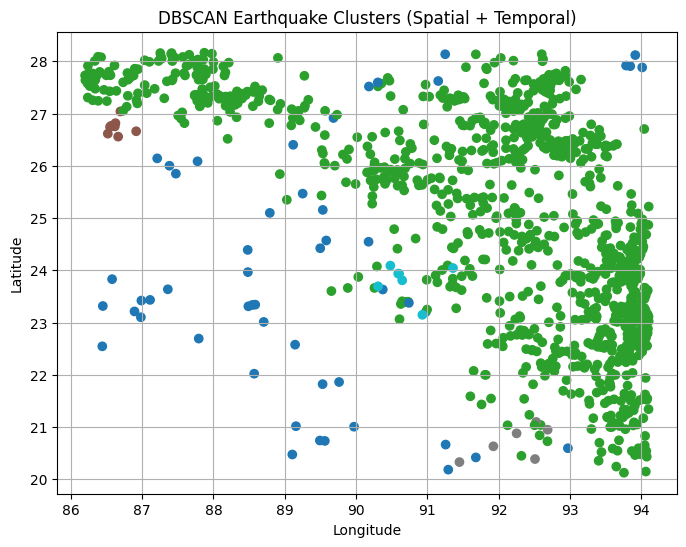

In [ ]:
# -------------------------------
# 8. Swarm Detection (DBSCAN Clustering)
# -------------------------------
# DBSCAN finds clusters without specifying
# the number beforehand—ideal for swarms.
# A cluster with many small quakes close together → swarm.
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize spatial + temporal dimensions
X = region_df[['latitude', 'longitude']].copy()
X['time_ordinal'] = region_df['time'].astype(np.int64) / 1e9  # convert ns to seconds
X_scaled = StandardScaler().fit_transform(X)

# DBSCAN (tune eps if needed)
db = DBSCAN(eps=0.4, min_samples=4).fit(X_scaled)
region_df['cluster'] = db.labels_

# Identify swarm clusters
swarm_clusters = region_df[region_df['cluster'] != -1].groupby('cluster').size()
swarm_clusters = swarm_clusters[swarm_clusters > 5]

print("Potential swarm clusters:")
print(swarm_clusters)

# Plot swarm clusters
plt.figure(figsize=(8,6))
plt.scatter(region_df['longitude'], region_df['latitude'], c=region_df['cluster'], cmap='tab10')
plt.title("DBSCAN Earthquake Clusters (Spatial + Temporal)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


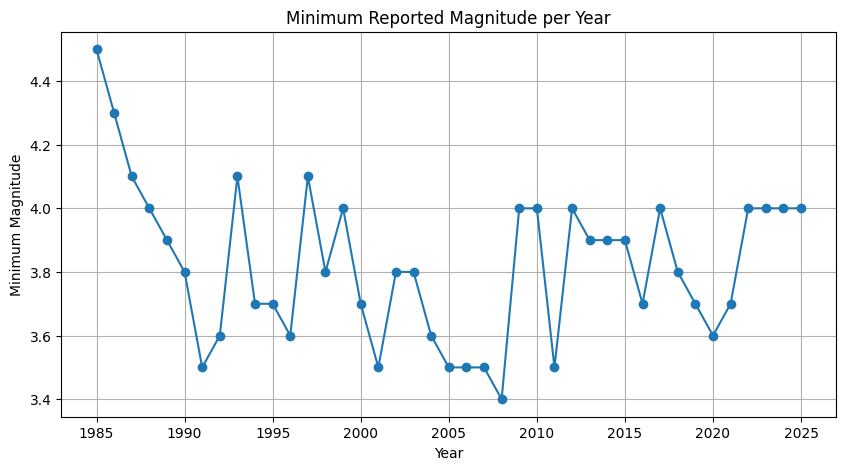

year
1985    4.5
1986    4.3
1987    4.1
1988    4.0
1989    3.9
1990    3.8
1991    3.5
1992    3.6
1993    4.1
1994    3.7
1995    3.7
1996    3.6
1997    4.1
1998    3.8
1999    4.0
2000    3.7
2001    3.5
2002    3.8
2003    3.8
2004    3.6
2005    3.5
2006    3.5
2007    3.5
2008    3.4
2009    4.0
2010    4.0
2011    3.5
2012    4.0
2013    3.9
2014    3.9
2015    3.9
2016    3.7
2017    4.0
2018    3.8
2019    3.7
2020    3.6
2021    3.7
2022    4.0
2023    4.0
2024    4.0
2025    4.0
Name: mag, dtype: float64


In [21]:
# -------------------------------
# 8. Minimum Detectable Magnitude Over Time
# -------------------------------
# This checks whether the system changed rather than the Earth.
# If sensors improved, the minimum recorded magnitude will drop.
min_mag_by_year = region_df.groupby('year')['mag'].min()

plt.figure(figsize=(10,5))
plt.plot(min_mag_by_year.index, min_mag_by_year.values, marker='o')
plt.title("Minimum Reported Magnitude per Year")
plt.xlabel("Year")
plt.ylabel("Minimum Magnitude")
plt.grid(True)
plt.show()

print(min_mag_by_year)


## 6. Are there any unusual aftershock or swarm patterns?

Questions:

- Did this year include one or more swarms?
- Are aftershock sequences larger or longer than past years?

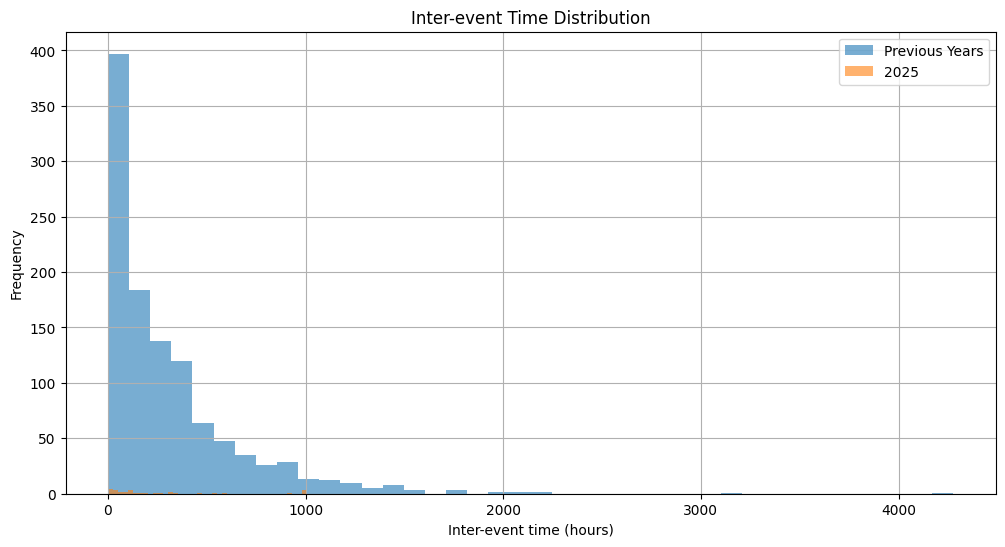

Median inter-event time (previous years): 191.08226666666667
Median inter-event time (2025): 149.43259444444445


In [16]:
## show for multiple years inter-event time comparison instead of only 2 years

# Sort by time
region_df = region_df.sort_values('time')

# Compute inter-event time deltas
region_df['delta_hours'] = region_df['time'].diff().dt.total_seconds() / 3600

# Compare this year vs previous years
current_df = region_df[region_df['year'] == current_year]
previous_df = region_df[region_df['year'] < current_year]

plt.figure(figsize=(12,6))
plt.hist(previous_df['delta_hours'].dropna(), bins=40, alpha=0.6, label='Previous Years')
plt.hist(current_df['delta_hours'].dropna(), bins=40, alpha=0.6, label=f'{current_year}')
plt.legend()
plt.xlabel("Inter-event time (hours)")
plt.ylabel("Frequency")
plt.title("Inter-event Time Distribution")
plt.grid(True)
plt.show()

print("Median inter-event time (previous years):", previous_df['delta_hours'].median())
print(f"Median inter-event time ({current_year}):", current_df['delta_hours'].median())


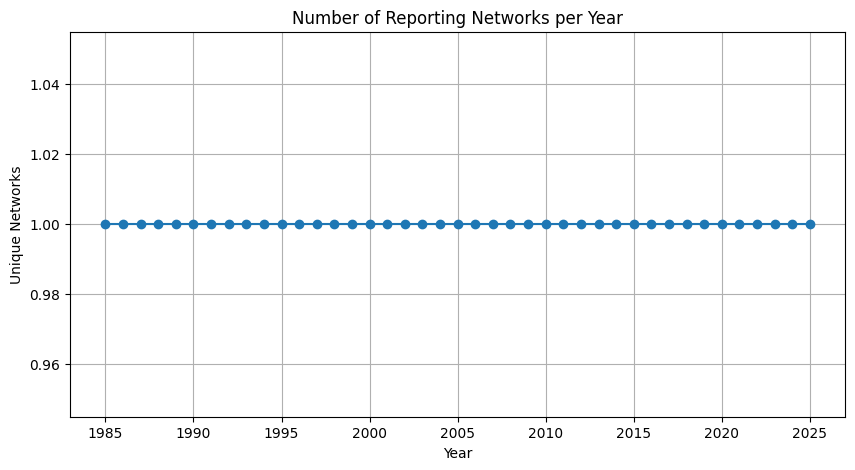

year
1985    1
1986    1
1987    1
1988    1
1989    1
1990    1
1991    1
1992    1
1993    1
1994    1
1995    1
1996    1
1997    1
1998    1
1999    1
2000    1
2001    1
2002    1
2003    1
2004    1
2005    1
2006    1
2007    1
2008    1
2009    1
2010    1
2011    1
2012    1
2013    1
2014    1
2015    1
2016    1
2017    1
2018    1
2019    1
2020    1
2021    1
2022    1
2023    1
2024    1
2025    1
Name: net, dtype: int64


In [22]:
# -------------------------------
# 8. Station Coverage (net / magSource changes)
# -------------------------------
# More stations/networks → more detections.
station_counts = region_df.groupby('year')['net'].nunique()

plt.figure(figsize=(10,5))
plt.plot(station_counts.index, station_counts.values, marker='o')
plt.title("Number of Reporting Networks per Year")
plt.xlabel("Year")
plt.ylabel("Unique Networks")
plt.grid(True)
plt.show()

print(station_counts)


## 7. Did detection conditions or reporting change?

Sometimes apparent changes come from better sensors.

Questions:

- Has the magnitude threshold of reported earthquakes shifted?
- Has station coverage improved in your region?

## 8. How does this year compare statistically?

If you want formal evidence:

Questions:

- Do statistical tests show significant difference in:
  - event rate?
  - magnitude distribution?
  - energy release?
  - depth distribution?

Tests might include:

- Poisson rate test for event frequency
- KS test for distributions
- ANOVA or Kruskal–Wallis for magnitude trends

In [13]:
# -------------------------------
# 8. STATISTICAL TESTS
# -------------------------------

current_year = region_df['year'].max()
prev_years_df = region_df[region_df['year'] < current_year]
current_df = region_df[region_df['year'] == current_year]

print("\n------- Statistical Tests -------")

# 1) Poisson test for event count change
lambda_prev = prev_years_df.groupby('year').size().mean()
count_current = len(current_df)

# Poisson probability of observing count_current given lambda_prev
p_value_poisson = poisson.pmf(count_current, lambda_prev)

print(f"Poisson test (count anomaly): p = {p_value_poisson}")

# 2) KS test on magnitude distribution
if len(current_df) > 0 and len(prev_years_df) > 0:
    ks_stat, ks_p = ks_2samp(current_df['mag'], prev_years_df['mag'])
    print(f"KS test (magnitude distribution): p = {ks_p}")
else:
    print("Not enough data for KS magnitude test.")

# 3) KS test on depth distribution
if len(current_df) > 0 and len(prev_years_df) > 0:
    ks_stat_d, ks_p_d = ks_2samp(current_df['depth'], prev_years_df['depth'])
    print(f"KS test (depth distribution): p = {ks_p_d}")
else:
    print("Not enough data for KS depth test.")

# 4) Energy comparison
if len(current_df) > 0:
    energy_current = current_df['energy_joules'].sum()
    energy_prev_avg = prev_years_df.groupby('year')['energy_joules'].sum().mean()
    print(f"Energy this year: {energy_current:.2e}, Previous average: {energy_prev_avg:.2e}")

print("--------------------------------")


------- Statistical Tests -------
Poisson test (count anomaly): p = 0.07133404627293334
KS test (magnitude distribution): p = 0.3950218151144281
KS test (depth distribution): p = 0.0027625376970510673
Energy this year: 3.42e+13, Previous average: 1.27e+14
--------------------------------
